### Customer Churn Prediction

In [7]:
### Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Load data
df = pd.read_csv("telco_customer_churn.csv")

# Deleting the customer ID collumn, unncessary
df.drop(columns=["customerID"], inplace=True)

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0.0)

# Check for missing values
print(df.isnull().sum())


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


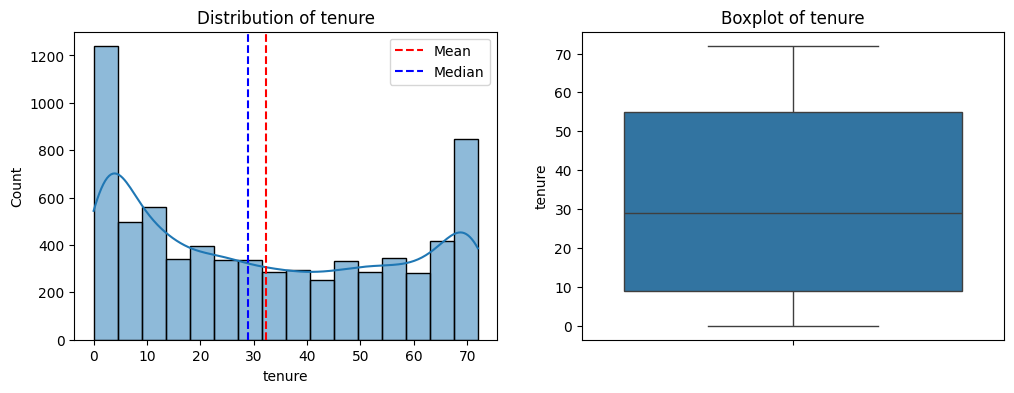

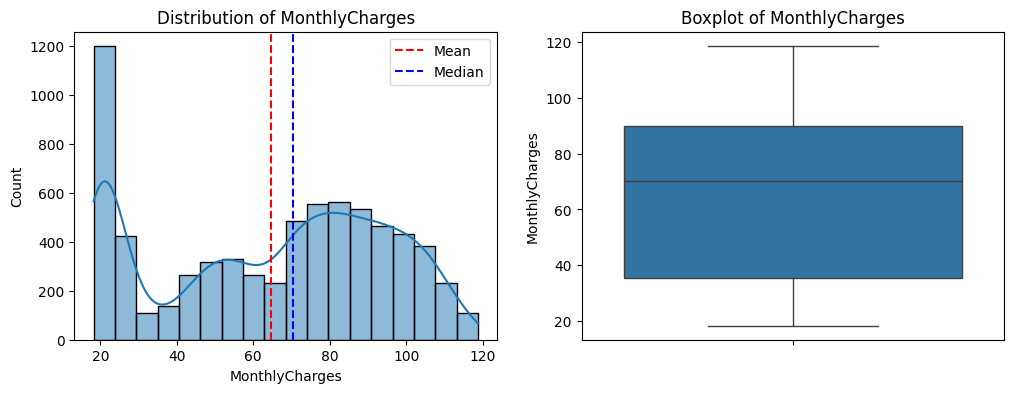

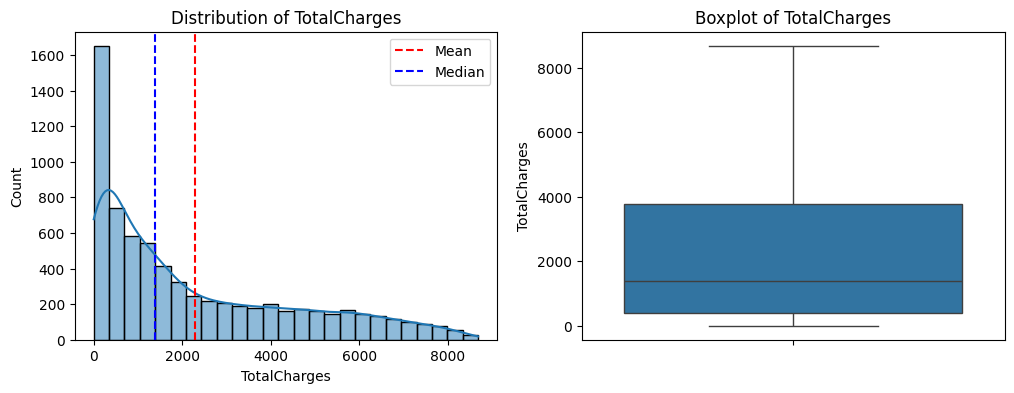

In [9]:
# Exploratory Data Analysis
def plot_distribution(df, column_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column_name], kde=True)
    plt.axvline(df[column_name].mean(), color="r", linestyle="--", label="Mean")
    plt.axvline(df[column_name].median(), color="b", linestyle="--", label="Median")
    plt.legend()
    plt.title(f"Distribution of {column_name}")
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[column_name])
    plt.title(f"Boxplot of {column_name}")
    plt.show()

for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    plot_distribution(df, col)


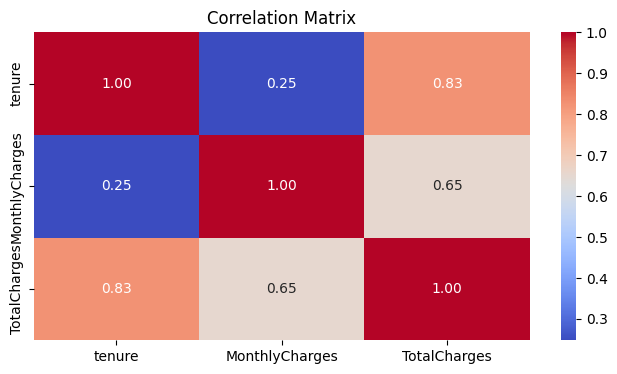

In [10]:
# Correlation Matrix
plt.figure(figsize=(8, 4))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [11]:
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

objects_columns = df.select_dtypes(include="object").columns.tolist()

# Check before removing
if "Churn" in objects_columns:
    objects_columns.remove("Churn")


In [12]:
# Label Encoding
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})
objects_columns = df.select_dtypes(include="object").columns.tolist()

encoders = {}
for column in objects_columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    encoders[column] = encoder

with open("encoder.pkl", "wb") as f:
    pickle.dump(encoders, f)


In [13]:
# Standardization
scaler = StandardScaler()
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [14]:
# Train-Test Split
X = df.drop(columns=["Churn"])
Y = df["Churn"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Handle Imbalance
smote = SMOTE(random_state=42)
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)


In [15]:
# Model Training
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

hyperparameters = {
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [5, 10, None]},
    "XGBoost": {"learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]}
}

best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}....")
    grid = GridSearchCV(model, hyperparameters[model_name], cv=3, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train_smote, Y_train_smote)
    best_models[model_name] = grid.best_estimator_
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    print(f"Best Accuracy for {model_name}: {grid.best_score_:.2f}\n")


Tuning Random Forest....
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Best Accuracy for Random Forest: 0.83

Tuning XGBoost....
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7}
Best Accuracy for XGBoost: 0.81



In [16]:
# Save Best Model
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_models["Random Forest"], f)

# Model Evaluation
Y_test_pred = best_models["Random Forest"].predict(X_test)
Y_test_prob = best_models["Random Forest"].predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(Y_test, Y_test_pred)}")
print(f"ROC-AUC Score: {roc_auc_score(Y_test, Y_test_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, Y_test_pred)}")
print(f"Classification Report:\n{classification_report(Y_test, Y_test_pred)}")


Accuracy: 0.7778566359119943
ROC-AUC Score: 0.7408482304594904
Confusion Matrix:
[[849 187]
 [126 247]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1036
           1       0.57      0.66      0.61       373

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.78      1409



In [17]:
# Prediction Function
def make_prediction(input_data):
    input_df = pd.DataFrame([input_data])
    
    # Encode categorical variables
    for col, encoder in encoders.items():
        input_df[col] = encoder.transform(input_df[col])
    
    # Standardize numerical variables
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])
    
    # Make prediction
    prediction = best_models["Random Forest"].predict(input_df)[0]
    probability = best_models["Random Forest"].predict_proba(input_df)[0, 1]
    
    return "Churn" if prediction == 1 else "No Churn", probability


In [18]:
# Example Input
test_input = {
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 1,
    "PhoneService": "No",
    "MultipleLines": "No phone service",
    "InternetService": "DSL",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "No",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 29.85,
    "TotalCharges": 29.85
}

prediction, prob = make_prediction(test_input)
print(f"Prediction: {prediction}, Probability: {prob:.2f}")

Prediction: No Churn, Probability: 0.27
